In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# PARAMETERS
STEPS = 500
DT = 1.0 / STEPS
BATCH_SIZE = 128
ITERS = 100
LAMBDA_REG = 0.005 # Regularization weight for control effort

In [3]:
# The Experts (or the pretrained drifts)
def drift_center(x):
    # Ornstein-Uhlenbeck process pulling to (0,0)
    return -1.0 * x 

In [4]:
class ControlNet2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x, t):
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

In [5]:
# Initialize Control Networks
ctrl1 = ControlNet2D()
ctrl2 = ControlNet2D()
# Combine parameters of both control networks for joint optimization
optimizer = optim.Adam(list(ctrl1.parameters()) + list(ctrl2.parameters()), lr=0.005)

# TRAINING LOOP - SOC VIA BACKPROPAGATION THROUGH TIME
print("Starting training...")
loss_history = []
for epoch in range(ITERS):
    optimizer.zero_grad()
    
    x1 = torch.randn(BATCH_SIZE, 2)
    x2 = torch.randn(BATCH_SIZE, 2)    
    control_cost = 0.0

    # Simulate Trajectory (Forward Pass)
    for i in range(STEPS):
        t_val = i * DT
        t_tensor = torch.full((BATCH_SIZE, 1), t_val)
        # Get Control from Networks
        u1 = ctrl1(x1, t_tensor)
        u2 = ctrl2(x2, t_tensor)
        # Get Drift from Prior Experts
        b1 = drift_center(x1)
        b2 = drift_center(x2)
        # SDE Update (Euler-Maruyama)
        noise = torch.randn(BATCH_SIZE, 2) * np.sqrt(DT)
        # Dynamics: dX = (drift + contorol)dt + dW
        x1 = x1 + (b1 + u1) * DT + noise
        x2 = x2 + (b2 + u2) * DT + (torch.randn_like(x1) * np.sqrt(DT))

        control_cost += torch.mean(u1**2 + u2**2) * DT

    # Terminal Cost (The Constraint)
    dist = torch.norm(x1 - x2, p=2, dim=1)
    target_dist = 4.0
    geo_loss = torch.mean((dist - target_dist)**2)
    # Total Loss
    loss = geo_loss + (LAMBDA_REG * control_cost)
    # Backward & Update
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f} (Dist: {geo_loss.item():.4f})")

print("--- Training Complete ---")

Starting training...
Epoch 0: Loss 7.8480 (Dist: 7.8479)
--- Training Complete ---


In [8]:
def generate_trajectories(n_pairs: int = 3):
    ctrl1.eval()
    ctrl2.eval()
    with torch.no_grad():
        x1 = torch.randn(n_pairs, 2)
        x2 = torch.randn(n_pairs, 2)
        
        # Store trajectories for plotting
        traj_x1 = np.zeros((n_pairs, STEPS+1, 2))
        traj_x2 = np.zeros((n_pairs, STEPS+1, 2))
        
        traj_x1[:, 0, :] = x1.numpy()
        traj_x2[:, 0, :] = x2.numpy()
        
        for i in range(STEPS):
            t_scalar = i * DT   
            t_tensor = torch.full((n_pairs, 1), t_scalar)
            
            u1 = ctrl1(x1, t_tensor)
            u2 = ctrl2(x2, t_tensor)
            
            x1 = x1 + (drift_center(x1) + u1) * DT 
            x2 = x2 + (drift_center(x2) + u2) * DT 
            
            traj_x1[:, i+1, :] = x1.numpy()
            traj_x2[:, i+1, :] = x2.numpy()

            
    return traj_x1, traj_x2
# Generate Data
print("Generating uncontrolled paths...")
traj_x1, traj_x2 = generate_trajectories()

Generating uncontrolled paths...


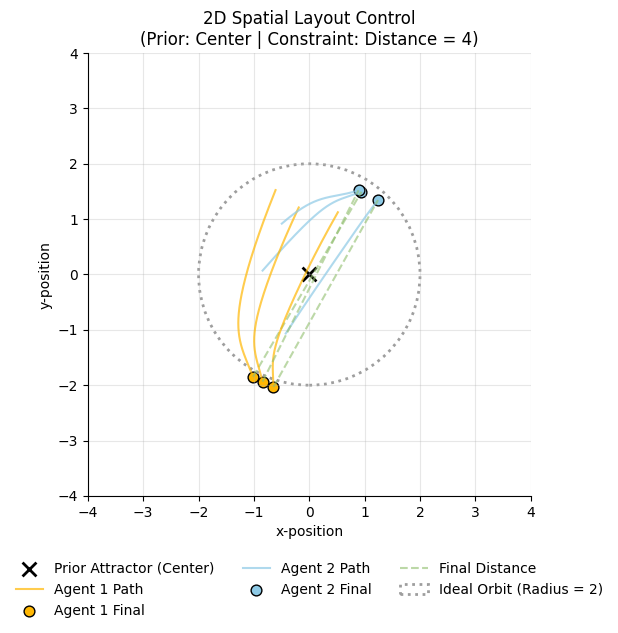

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6.5, 6.5))
ax.set_title("2D Spatial Layout Control\n(Prior: Center | Constraint: Distance = 4)")

# Pastel colors
color_a1 = "#ffb703"  # Agent 1 (orange)
color_a2 = "#8ecae6"  # Agent 2 (blue)
color_conn = "#90be6d"  # soft green for connections
color_ring = "#9e9e9e"  # grey for orbit

center = ax.scatter(0, 0, c="black", marker="x", s=100, linewidths=2)
path1 = path2 = final1 = final2 = conn_line = None

# Trajectories
n_agents = traj_x1.shape[0]
for k in range(n_agents):
    # Agent 1
    p1, = ax.plot(traj_x1[k, :, 0], traj_x1[k, :, 1],
                  c=color_a1, alpha=0.7, linewidth=1.5)
    f1 = ax.scatter(traj_x1[k, -1, 0], traj_x1[k, -1, 1],
                    c=color_a1, edgecolors="black", s=60)

    # Agent 2
    p2, = ax.plot(traj_x2[k, :, 0], traj_x2[k, :, 1],
                  c=color_a2, alpha=0.7, linewidth=1.5)
    f2 = ax.scatter(traj_x2[k, -1, 0], traj_x2[k, -1, 1],
                    c=color_a2, edgecolors="black", s=60)

    # Connection between final positions
    c_line, = ax.plot(
        [traj_x1[k, -1, 0], traj_x2[k, -1, 0]],
        [traj_x1[k, -1, 1], traj_x2[k, -1, 1]],
        c=color_conn, linestyle="--", alpha=0.6, linewidth=1.5
    )

    # save only once for legend
    if k == 0:
        path1, final1, path2, final2, conn_line = p1, f1, p2, f2, c_line

# Target ring (ideal orbit)
circle = plt.Circle((0, 0), 2.0, edgecolor=color_ring,
                    fill=False, linestyle=":", linewidth=2)
ax.add_patch(circle)

# Axes settings
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect("equal", "box")
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")

# Grid & spines
ax.grid(True, alpha=0.3)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend at bottom
ax.legend(
    [center, path1, final1, path2, final2, conn_line, circle],
    [
        "Prior Attractor (Center)",
        "Agent 1 Path", "Agent 1 Final",
        "Agent 2 Path", "Agent 2 Final",
        "Final Distance",
        "Ideal Orbit (Radius = 2)",
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()